In [14]:
import math
import sys
import copy
import numpy as np

In [15]:
# function for checking format of data in readlines
def real_PDB_data_check(data):
    if len(data) != 12:
        if len(data[2]) > 4:
            return -1 # Amino acid name stick with info before
    else:
        if len(data[3]) == 3:
            return 1 # True data
        else: 
            return -2 # Wrong amino acid name


# This function will go over every atom between two chains to determine whether they are interacting (distance smaller
# than 3.5A)
# remember to import math package when use the function
# Input variables:
# return variables: a tuple includes
def real_PDB_chain_int(unique_chain, split_position, split_resi_count, split_atom_count, split_resi_type, split_atom_type, split_resi_position):
    distance = 0
    reaction_chain = [] # list of lists (each sublist will include two letters indicating these two chains have
    # interaction) eg: in this protein, only chain A&B, A&D and C&D are interacting, then the list will look like
    # [[A,B],[A,D],[C,D]]
    reaction_resi_type = [] # list of lists of lists(each sub-sublist will include a bunch of lists of residue pairs
    # (without repeats)) eg: [[[resia,resib],[resic,resid]],[[resie,resif],[resig,resih]],[[resii,resij],[resik,resil]]]
    # ----reaction residues of chain-------- A&B------------------------A&D-------------------------C&D -------------
    reaction_resi_count = []
    reaction_atom = []
    reaction_atom_position = []
    reaction_atom_distance = []
    reaction_atom_type = []
    reaction_resi_position = []

    for i in range(len(unique_chain) - 1):
        for j in range(i+1, len(unique_chain)):
            inner_atom_position = []
            inner_atom_distance = []
            inner_atom = []
            inner_reaction_resi_count = []
            inner_reaction_resi_type = []
            inner_reaction_atom_type = []
            inner_reaction_resi_position = []

            for m in range(len(split_position[i])):
                for n in range(len(split_position[j])):
                    distance = math.sqrt((split_position[i][m][0]-split_position[j][n][0])**2
                                         + (split_position[i][m][1]-split_position[j][n][1])**2
                                         + (split_position[i][m][2]-split_position[j][n][2])**2)
                    if distance <= 0.3:
                        inner_atom.append([split_atom_count[i][m], split_atom_count[j][n]])
                        inner_atom_distance.append(distance)
                        inner_atom_position.append([split_position[i][m], split_position[j][n]])
                        inner_reaction_atom_type.append([split_atom_type[i][m], split_atom_type[j][n]])
                        if [split_resi_count[i][m], split_resi_count[j][n]] not in inner_reaction_resi_count:
                            inner_reaction_resi_count.append([split_resi_count[i][m], split_resi_count[j][n]])
                            inner_reaction_resi_position.append([split_resi_position[i][m], split_resi_position[j][n]])
                            inner_reaction_resi_type.append([split_resi_type[i][m], split_resi_type[j][n]])

            if len(inner_reaction_resi_count) > 0:
                reaction_chain.append([unique_chain[i], unique_chain[j]])
                reaction_resi_count.append(inner_reaction_resi_count)
                reaction_resi_type.append(inner_reaction_resi_type)
                reaction_atom.append(inner_atom)
                reaction_atom_position.append(inner_atom_position)
                reaction_atom_distance.append(inner_atom_distance)
                reaction_atom_type.append(inner_reaction_atom_type)
                reaction_resi_position.append(inner_reaction_resi_position)
    return reaction_chain, reaction_atom, reaction_atom_position, reaction_atom_distance, reaction_resi_count, \
           reaction_resi_type, reaction_atom_type, reaction_resi_position


def real_PDB_unit(x:np.ndarray) -> np.ndarray:
    '''Get the unit vector of x\n
    Return 0 if ||x||=0\n
    Return itself if ||x||=1'''
    x_norm = np.linalg.norm(x)
    if abs(x_norm-1) < 10**-6:
        return x
    elif x_norm < 10**-6:
        return np.zeros(3)
    else:
        return x/x_norm


def real_PDB_triangle_correction(x: float) -> float:
    '''make x in range of [-1, 1], correct precision'''
    if x < -1 and abs(x+1) < 10**-6:
        return -1
    elif x > 1 and abs(x-1) < 10**-6:
        return 1
    elif -1 <= x <= 1:
        return x
    else:
        raise ValueError(f'{x} is out of the range of sin/cos')

def real_PDB_calculate_phi(v:np.ndarray, n:np.ndarray, sigma:np.ndarray) -> float:

    # calculate phi
    t1 = real_PDB_unit(np.cross(v, sigma))
    t2 = real_PDB_unit(np.cross(v, n))
    phi = math.acos(real_PDB_triangle_correction(np.dot(t1, t2)))

    # determine the sign of phi (+/-)
    v_uni = real_PDB_unit(v)
    n_proj = n - v_uni * np.dot(v_uni, n)
    sigma_proj = sigma - v_uni * np.dot(v_uni, sigma)
    phi_dir = real_PDB_unit(np.cross(sigma_proj, n_proj))

    if np.dot(v_uni, phi_dir) > 0:
        phi = -phi
    else:
        phi = phi
    
    return phi


# This function will calculate five necessary angles: theta_one, theta_two, phi_one, phi_two and omega
# Input variables: four coordinates indicating COM and interaction site of two chains
# First created by Yian Qian
# Modified by Mankun Sang on 04/13/2022 
#   1) unit of zero vector and length-one vector
#   2) error messages when v // n
#   3) test scripts
# Modified by Yian Qian & Mankun Sang on 04/16/2022
#   0) correct omega calculation when n // sigma
#   1) generalize the sign determination of phi and omega
#   2) created a function for phi cacluation
def real_PDB_angles(COM1, COM2, int_site1, int_site2, normal_point1, normal_point2):
    '''Calculate the angles for binding'''

    # Convert sequences into arrays for convinience
    COM1 = np.array(COM1)
    COM2 = np.array(COM2)
    int_site1 = np.array(int_site1)
    int_site2 = np.array(int_site2)
    normal_point1 = np.array(normal_point1)
    normal_point2 = np.array(normal_point2)

    # Get Vectors
    v1 = int_site1 - COM1 # from COM to interface (particle 1)
    v2 = int_site2 - COM2  # from COM to interface (particle 2)
    sigma1 = int_site1 - int_site2 # sigma, from p2 to p1
    sigma2 = int_site2 - int_site1  # sigma, from p1 to p2
    n1 = real_PDB_unit(normal_point1 - COM1) # normal vector for p1
    n2 = real_PDB_unit(normal_point2 - COM2) # normal vector for p2

    # Calculate the magnititude of sigma
    sigma_magnitude = np.linalg.norm(sigma1)

    # Calculate theta1 and theta2
    costheta1 = np.dot(v1, sigma1) / np.linalg.norm(v1) / np.linalg.norm(sigma1)
    costheta2 = np.dot(v2, sigma2) / np.linalg.norm(v2) / np.linalg.norm(sigma2)
    theta1 = math.acos(real_PDB_triangle_correction(costheta1))
    theta2 = math.acos(real_PDB_triangle_correction(costheta2))

    # check geometry
    errormsg = ''
    iferror = False # determine if v // n
    if np.linalg.norm(np.cross(n1, v1)) < 10**-6:
        iferror = True
        errormsg += '\n\tn1 and v1 parallel, phi1 not available'
    if np.linalg.norm(np.cross(n2, v2)) < 10**-6:
        iferror = True
        errormsg += '\n\tn2 and v2 parallel, phi2 not available'
    if iferror:
        raise ValueError(errormsg)

    # determine if phi1 exists (v1 // sigma1 ?)
    if np.linalg.norm(np.cross(sigma1, v1)) < 10**-6:
        phi1 = float('nan')
        # omega_parallel = True
        omega_t1 = real_PDB_unit(np.cross(sigma1, n1))
    else:
        phi1 = real_PDB_calculate_phi(v1, n1, sigma1)
        omega_t1 = real_PDB_unit(np.cross(sigma1, v1))

    # determine if phi2 exists (v2 // sigma2 ?)
    if np.linalg.norm(np.cross(sigma2, v2)) < 10**-6:
        phi2 = float('nan')
        # omega_parallel = True
        omega_t2 = real_PDB_unit(np.cross(sigma1, n2))
    else:
        phi2 = real_PDB_calculate_phi(v2, n2, sigma2)
        omega_t2 = real_PDB_unit(np.cross(sigma1, v2))

    # calculate omega (both cases are same)
    omega = math.acos(real_PDB_triangle_correction(np.dot(omega_t1, omega_t2)))
    # determine the sign of omega (+/-)
    sigma1_uni = real_PDB_unit(sigma1)
    sigma1xomega_t1 = np.cross(sigma1, omega_t1)
    sigma1xomega_t2 = np.cross(sigma1, omega_t2)
    omega_dir = real_PDB_unit(np.cross(sigma1xomega_t1, sigma1xomega_t2))
    if np.dot(sigma1_uni, omega_dir) > 0:
        omega = -omega
    else:
        omega = omega

    return theta1, theta2, phi1, phi2, omega, sigma_magnitude



def real_PDB_norm_check(norm, COM, site, buffer_ratio = 1e-3):
    '''
    norm is a 3D vector
    COM is a point
    site is a point
    False: continue norm calculation
    True: requesting redo input
    '''
    for i in norm:
        if type(i) != float:
            return True
    for i in COM:
        if type(i) != float:
            return True
    for i in site:
        if type(i) != float:
            return True
    if len(norm) != 3 or len(COM) != 3 or len(site) != 3:
        return True
    if norm == [0, 0, 0]:
        return True
    norm = np.array(norm)
    COM = np.array(COM)
    site = np.array(site)
    vec1 = norm
    vec2 = site - COM
    zero_pos_1 = []
    zero_pos_2 = []
    for i in range(len(vec1)):
        if vec1[i] == 0:
            zero_pos_1.append(i)
    for i in range(len(vec2)):
        if vec2[i] == 0:
            zero_pos_2.append(i)
    if len(zero_pos_1) == 1 and len(zero_pos_2) == 1 and zero_pos_1 == zero_pos_2:
        pool = [0, 1, 2]
        pool.remove(zero_pos_1[0])
        ratio = vec1[pool[0]]/vec2[pool[0]]
        if vec1[pool[1]]/vec2[pool[1]] >= ratio*(1-buffer_ratio) and vec1[pool[1]]/vec2[pool[1]] <= ratio*(1+buffer_ratio):
            return True
        else:
            return False
    elif len(zero_pos_1) == 1 and len(zero_pos_2) == 1 and zero_pos_1 != zero_pos_2:
        return False
    elif len(zero_pos_1) == 2 and len(zero_pos_2) == 2 and zero_pos_1 == zero_pos_2:
        return True
    elif len(zero_pos_1) == 2 and len(zero_pos_2) == 2 and zero_pos_1 != zero_pos_2:
        return False
    elif len(zero_pos_1) != len(zero_pos_2):
        return False
    else:
        ratio = vec1[0]/vec2[0]
        if ratio >= 0:
            if vec1[1]/vec2[1] >= ratio*(1-buffer_ratio) and vec1[1]/vec2[1] <= ratio*(1+buffer_ratio):
                if vec1[2]/vec2[2] >= ratio*(1-buffer_ratio) and vec1[2]/vec2[2] <= ratio*(1+buffer_ratio):
                    return True
                else:
                    return False
            else:
                return False
        if ratio < 0:
            if vec1[1]/vec2[1] >= ratio*(1+buffer_ratio) and vec1[1]/vec2[1] <= ratio*(1-buffer_ratio):
                if vec1[2]/vec2[2] >= ratio*(1+buffer_ratio) and vec1[2]/vec2[2] <= ratio*(1-buffer_ratio):
                    return True
                else:
                    return False
            else:
                return False


def real_PDB_norm_input(normal_point_lst, chain_name, chain_pair1, chain_pair2):
    normal_point_1_temp = input('Please input normal vector for ' + chain_name + ' in chain ' + chain_pair1 + " & " + chain_pair2 + ' : ')
    normal_point_1_temp = normal_point_1_temp.strip('[').strip(']').split(',')
    normal_point_1_temp_ = []
    for j in normal_point_1_temp:
        normal_point_1_temp_.append(float(j))
    normal_point_lst.append(normal_point_1_temp_)
    return normal_point_lst


def real_PDB_mag(x):
    return math.sqrt(sum(i ** 2 for i in x))


In [16]:
def real_PDB_separate_read(FileName:str):
    total_atom_count = []
    # specific chain the atom belongs to (such as A or B or C, etc).
    total_chain = []
    total_resi_count = []  # residue number
    total_position = []  # the coordinate of each atom
    total_atom_type = []  # to show whether the atom is a alpha carbon, N, etc.
    total_resi_type = []  # to show the type of residue
    # indicate the position of alpha carbon of the residue the atom is in.
    total_resi_position_every_atom = []
    total_resi_position = []  # list of position of all alpha carbon atom position
    total_alphaC_resi_count = []  # indicate which residue the alphaC belongs to
    # The length of last two lists are the same as total residue numbers in the chain and the length of rest of the lists
    # are the same as total atom numbers in the protein.
    # read in user pdb file
    # out data into corresponding lists
    with open(FileName, "r") as filename:
        for line in filename:
            data = line.split()  # split a line into list
            id = data[0]
            if id == 'ENDMDL':
                break
            if id == 'ATOM':  # find all 'atom' lines
                if real_PDB_data_check(data) == 1:
                    pass
                elif real_PDB_data_check(data) == -2:
                    data[3] = data[3].lstrip(data[3][0])
                elif real_PDB_data_check(data) == -1:
                    amino_name = data[2][-3:]
                    data.insert(3, amino_name)
                    data[2] = data[2].rstrip(amino_name)

                total_atom_count.append(data[1])
                total_chain.append(data[4])
                total_resi_count.append(data[5])
                total_atom_type.append(data[2])
                total_resi_type.append(data[3])
                # change all strings into floats for position values, also converting to nm from angstroms
                position_coords = []
                for i in range(3):
                    position_coords.append(float(data[6+i])/10)
                total_position.append(position_coords)
                if data[2] == "CA":
                    total_resi_position.append(position_coords)
                    total_alphaC_resi_count.append(data[5])
    print('Finish reading pdb file')

    # create total_resi_position_every_atom list
    count = 0
    for i in range(len(total_alphaC_resi_count)):
        if count >= len(total_atom_type):
            break
        for j in range(count, len(total_atom_type)):
            if total_resi_count[j] == total_alphaC_resi_count[i]:
                total_resi_position_every_atom.append(total_resi_position[i])
                count = count + 1
            else:
                break

    # determine how many unique chains exist
    unique_chain = []
    for letter in total_chain:
        if letter not in unique_chain:
            unique_chain.append(letter)
    print(str(len(unique_chain)) + ' chain(s) in total: ' + str(unique_chain))

    # exit if there's only one chain.
    if len(unique_chain) == 1:
        sys.exit()

    # create lists of lists where each sublist contains the data for different chains.
    split_atom_count = []
    split_chain = []
    split_resi_count = []
    split_position = []
    split_atom_type = []
    split_resi_type = []
    chain_end_atom = []
    split_resi_position_every_atom = []

    # inner lists are sublists of each list, each of the sublist represents data about a list
    inner_atom_count = []
    inner_chain = []
    inner_resi_count = []
    inner_position = []
    inner_atom_type = []
    inner_resi_type = []
    inner_resi_position_every_atom = []

    # determine number of atoms in each chain
    chain_counter = 0

    for i in range(len(total_atom_count)):

        if total_chain[i] != unique_chain[chain_counter]:
            split_atom_count.append(inner_atom_count)
            split_chain.append(inner_chain)
            split_resi_count.append(inner_resi_count)
            split_position.append(inner_position)
            split_atom_type.append(inner_atom_type)
            split_resi_type.append(inner_resi_type)
            split_resi_position_every_atom.append(inner_resi_position_every_atom)
            inner_atom_count = []
            inner_chain = []
            inner_resi_count = []
            inner_position = []
            inner_atom_type = []
            inner_resi_type = []
            inner_resi_position_every_atom = []
            chain_end_atom.append(len(split_atom_count[chain_counter]))
            chain_counter = chain_counter + 1

        if total_chain[i] == unique_chain[chain_counter]:
            inner_atom_count.append(total_atom_count[i])
            inner_chain.append(total_chain[i])
            inner_resi_count.append(total_resi_count[i])
            inner_position.append(total_position[i])
            inner_atom_type.append(total_atom_type[i])
            inner_resi_type.append(total_resi_type[i])
            inner_resi_position_every_atom.append(
                total_resi_position_every_atom[i])

        if i == (len(total_atom_count) - 1):
            split_atom_count.append(inner_atom_count)
            split_chain.append(inner_chain)
            split_resi_count.append(inner_resi_count)
            split_position.append(inner_position)
            split_atom_type.append(inner_atom_type)
            split_resi_type.append(inner_resi_type)
            split_resi_position_every_atom.append(inner_resi_position_every_atom)
            chain_end_atom.append(len(split_atom_count[chain_counter]))

    print('Each of them has ' + str(chain_end_atom) + ' atoms.')

    # determine the interaction between each two chains by using function chain_int()
    # the output is a tuple with 7 list of list including: reaction_chain, reaction_atom, reaction_atom_position,
    # reaction_atom_distance, reaction_resi_count, reaction_resi_type and  reaction_atom_type

    interaction = real_PDB_chain_int(unique_chain, split_position, split_resi_count, split_atom_count,
                            split_resi_type, split_atom_type, split_resi_position_every_atom)
    reaction_chain = interaction[0]
    reaction_atom = interaction[1]
    reaction_atom_position = interaction[2]
    reaction_atom_distance = interaction[3]
    reaction_resi_count = interaction[4]
    reaction_resi_type = interaction[5]
    reaction_atom_type = interaction[6]
    reaction_resi_position = interaction[7]

    # calculating center of mass (COM) and interaction site

    # COM
    COM = []
    for i in range(len(split_position)):
        sumx = 0
        sumy = 0
        sumz = 0
        for j in range(len(split_position[i])):
            sumx = sumx + split_position[i][j][0]
            sumy = sumy + split_position[i][j][1]
            sumz = sumz + split_position[i][j][2]
        inner_COM = [sumx / len(split_position[i]), sumy /
                    len(split_position[i]), sumz / len(split_position[i])]
        COM.append(inner_COM)

    for i in range(len(COM)):
        print("Center of mass of  " + unique_chain[i] + " is: " +
            "[%.3f, %.3f, %.3f]" % (COM[i][0], COM[i][1], COM[i][2]))


    # int_site
    int_site = []
    two_chain_int_site = []

    for i in range(len(reaction_resi_position)):
        for j in range(0, 2):
            sumx = 0
            sumy = 0
            sumz = 0
            count = 0
            added_position = []
            for k in range(len(reaction_resi_position[i])):
                if reaction_resi_position[i][k][j] not in added_position:
                    sumx = sumx + reaction_resi_position[i][k][j][0]
                    sumy = sumy + reaction_resi_position[i][k][j][1]
                    sumz = sumz + reaction_resi_position[i][k][j][2]
                    added_position.append(reaction_resi_position[i][k][j])
                    count = count + 1
            inner_int_site = [sumx / count, sumy / count, sumz / count]
            two_chain_int_site.append(inner_int_site)
        int_site.append(two_chain_int_site)
        two_chain_int_site = []


    # calculate distance between interaction site.
    int_site_distance = []
    for i in range(len(int_site)):
        distance = math.sqrt((int_site[i][0][0] - int_site[i][1][0]) ** 2 + (int_site[i][0][1] - int_site[i][1][1]) ** 2
                            + (int_site[i][0][2] - int_site[i][1][2]) ** 2)
        int_site_distance.append(distance)

    for i in range(len(int_site)):
        print("Interaction site of " + reaction_chain[i][0] + " & " + reaction_chain[i][1] + " is: "
            + "[%.3f, %.3f, %.3f]" % (int_site[i][0][0],
                                        int_site[i][0][1], int_site[i][0][2]) + " and "
            + "[%.3f, %.3f, %.3f]" % (int_site[i][1][0],
                                        int_site[i][1][1], int_site[i][1][2])
            + " distance between interaction sites is: %.3f nm" % (int_site_distance[i]))

    return reaction_chain, int_site, int_site_distance, unique_chain, COM

In [38]:
def real_PDB_separate_filter(Result:tuple, ChainList:list):
    reaction_chain, int_site, int_site_distance, unique_chain, COM = Result
    int_index = []
    for i in range(len(reaction_chain)):
        if reaction_chain[i][0] in ChainList and reaction_chain[i][1] in ChainList:
            int_index.append(i)
    reaction_chain_ = []
    int_site_ = []
    int_site_distance_ = []
    for i in range(len(int_index)):
        reaction_chain_.append(reaction_chain[i])
        int_site_.append(int_site[i])
        int_site_distance_.append(int_site_distance[i])
    chain_index = []
    for i in range(len(unique_chain)):
        if unique_chain[i] in ChainList:
            chain_index.append(i)
    unique_chain_ = []
    COM_ = []
    for i in range(len(chain_index)):
        unique_chain_.append(unique_chain[i])
        COM_.append(COM[i])
    print('After filter with', ChainList, ':')
    print(str(len(unique_chain_)) + ' chain(s) in total: ' + str(unique_chain_))
    for i in range(len(COM_)):
        print("Center of mass of  " + unique_chain_[i] + " is: " +
            "[%.3f, %.3f, %.3f]" % (COM_[i][0], COM_[i][1], COM_[i][2]))
    for i in range(len(int_site_)):
        print("Interaction site of " + reaction_chain_[i][0] + " & " + reaction_chain_[i][1] + " is: "
            + "[%.3f, %.3f, %.3f]" % (int_site_[i][0][0],
                                        int_site_[i][0][1], int_site_[i][0][2]) + " and "
            + "[%.3f, %.3f, %.3f]" % (int_site_[i][1][0],
                                        int_site_[i][1][1], int_site_[i][1][2])
            + " distance between interaction sites is: %.3f nm" % (int_site_distance_[i]))

    return reaction_chain_, int_site_, int_site_distance_, unique_chain_, COM_

# result1 = real_PDB_separate_read(FileName='1utc.pdb')
# real_PDB_separate_filter(result1, ['A', 'B'])


In [39]:
def real_PDB_separate_sigma(Result:tuple, ChangeSigma:bool = False, SiteList:list = [], NewSigma:list = []):

    reaction_chain, int_site, int_site_distance, unique_chain, COM = Result
    # user can choose to change the interaction site
    new_int_site_distance = copy.deepcopy(int_site_distance)
    new_int_site = copy.deepcopy(int_site)
    if ChangeSigma:
        for i in range(len(SiteList)):
            n = SiteList[i] - 1
            new_distance = NewSigma[i]
            if new_distance >= 0:
                if n == -1:
                    for p in range(0, len(reaction_chain)):
                        new_int_site_distance[p] = copy.deepcopy(
                            new_distance)
                        dir_vec1 = (
                            int_site[p][0][0] -
                            int_site[p][1][0], int_site[p][0][1] -
                            int_site[p][1][1],
                            int_site[p][0][2] - int_site[p][1][2])
                        dir_vec2 = (
                            int_site[p][1][0] -
                            int_site[p][0][0], int_site[p][1][1] -
                            int_site[p][0][1],
                            int_site[p][1][2] - int_site[p][0][2])
                        unit_dir_vec1 = [dir_vec1[0] / real_PDB_mag(dir_vec1), dir_vec1[1] / real_PDB_mag(dir_vec1),
                                        dir_vec1[2] / real_PDB_mag(dir_vec1)]
                        unit_dir_vec2 = [dir_vec2[0] / real_PDB_mag(dir_vec2), dir_vec2[1] / real_PDB_mag(dir_vec2),
                                        dir_vec2[2] / real_PDB_mag(dir_vec2)]

                        inner_new_position = []
                        new_coord1 = []
                        new_coord2 = []
                        for i in range(3):
                            new_coord1.append(
                                (new_distance - int_site_distance[p]) / 2 * unit_dir_vec1[i] + int_site[p][0][
                                    i])
                            new_coord2.append(
                                (new_distance - int_site_distance[p]) / 2 * unit_dir_vec2[i] + int_site[p][1][
                                    i])
                        inner_new_position.append(new_coord1)
                        inner_new_position.append(new_coord2)

                        new_int_site[p] = copy.deepcopy(
                            inner_new_position)
                        new_int_site_distance[p] = math.sqrt(
                            (new_int_site[p][0][0] -
                            new_int_site[p][1][0]) ** 2
                            + (new_int_site[p][0][1] -
                            new_int_site[p][1][1]) ** 2
                            + (new_int_site[p][0][2] - new_int_site[p][1][2]) ** 2)
                        # print("New interaction site of " + reaction_chain[p][0] + " & " + reaction_chain[p][
                        #     1] + " is: "
                        #     + "[%.3f, %.3f, %.3f]" % (
                        #     new_int_site[p][0][0], new_int_site[p][0][1], new_int_site[p][0][2]) + " and "
                        #     + "[%.3f, %.3f, %.3f]" % (
                        #     new_int_site[p][1][0], new_int_site[p][1][1], new_int_site[p][1][2])
                        #     + " distance between interaction sites is: %.3f" % (new_int_site_distance[p]))
                if n >= 0:
                    new_int_site_distance[n] = copy.deepcopy(
                        new_distance)
                    dir_vec1 = (int_site[n][0][0] - int_site[n][1][0], int_site[n][0]
                                [1] - int_site[n][1][1], int_site[n][0][2] - int_site[n][1][2])
                    dir_vec2 = (int_site[n][1][0] - int_site[n][0][0], int_site[n][1]
                                [1] - int_site[n][0][1], int_site[n][1][2] - int_site[n][0][2])
                    unit_dir_vec1 = [
                        dir_vec1[0] / real_PDB_mag(dir_vec1), dir_vec1[1] / real_PDB_mag(dir_vec1), dir_vec1[2] / real_PDB_mag(dir_vec1)]
                    unit_dir_vec2 = [
                        dir_vec2[0] / real_PDB_mag(dir_vec2), dir_vec2[1] / real_PDB_mag(dir_vec2), dir_vec2[2] / real_PDB_mag(dir_vec2)]

                    inner_new_position = []
                    new_coord1 = []
                    new_coord2 = []
                    for i in range(3):
                        new_coord1.append(
                            (new_distance - int_site_distance[n]) / 2 * unit_dir_vec1[i] + int_site[n][0][i])
                        new_coord2.append(
                            (new_distance - int_site_distance[n]) / 2 * unit_dir_vec2[i] + int_site[n][1][i])
                    inner_new_position.append(new_coord1)
                    inner_new_position.append(new_coord2)

                    new_int_site[n] = copy.deepcopy(inner_new_position)
                    new_int_site_distance[n] = math.sqrt((new_int_site[n][0][0] - new_int_site[n][1][0]) ** 2
                                                        + (new_int_site[n][0][1] - new_int_site[n][1][1]) ** 2
                                                        + (new_int_site[n][0][2] - new_int_site[n][1][2]) ** 2)
                    # print("New interaction site of " + reaction_chain[n][0] + " & " + reaction_chain[n][1] + " is: "
                    #     + "[%.3f, %.3f, %.3f]" % (
                    #         new_int_site[n][0][0], new_int_site[n][0][1], new_int_site[n][0][2]) + " and "
                    #     + "[%.3f, %.3f, %.3f]" % (
                    #     new_int_site[n][1][0], new_int_site[n][1][1], new_int_site[n][1][2])
                    #     + " distance between interaction sites is: %.3f" % (new_int_site_distance[n]) + ' nm')
        
        for i in range(len(new_int_site)):
            print("New interaction site of " + reaction_chain[i][0] + " & " + reaction_chain[i][1] + " is: "
                + "[%.3f, %.3f, %.3f]" % (new_int_site[i][0][0],
                                            new_int_site[i][0][1], new_int_site[i][0][2]) + " and "
                + "[%.3f, %.3f, %.3f]" % (new_int_site[i][1][0],
                                            new_int_site[i][1][1], new_int_site[i][1][2])
                + " distance between new interaction sites is: %.3f nm" % (new_int_site_distance[i]))

        return reaction_chain, new_int_site, new_int_site_distance, unique_chain, COM
        
    else:
        return Result


In [40]:
def real_PDB_separate_angle(Result: tuple):
    reaction_chain, new_int_site, new_int_site_distance, unique_chain, COM = Result
    angle = []
    normal_point_lst1 = []
    normal_point_lst2 = []
    for i in range(len(reaction_chain)):
            chain1 = 0
            chain2 = 0
            for j in range(len(unique_chain)):
                if reaction_chain[i][0] == unique_chain[j]:
                    chain1 = j
                if reaction_chain[i][1] == unique_chain[j]:
                    chain2 = j
                if reaction_chain[i][0] == unique_chain[chain1] and reaction_chain[i][1] == unique_chain[chain2]:
                    break
            while True:
                normal_point_lst1.append([0., 0., 1.])
                if real_PDB_norm_check(normal_point_lst1[-1], COM[chain1], new_int_site[i][0]) == False:
                    break
                else:
                    normal_point_lst1.remove(normal_point_lst1[-1])
                    normal_point_lst1.append([0., 1., 0.])

            while True:
                normal_point_lst2.append([0., 0., 1.])
                if real_PDB_norm_check(normal_point_lst2[-1], COM[chain2], new_int_site[i][1]) == False:
                    break
                else:
                    normal_point_lst2.remove(normal_point_lst2[-1])
                    normal_point_lst2.append([0., 1., 0.])

            inner_angle = real_PDB_angles(COM[chain1], COM[chain2], new_int_site[i][0], new_int_site[i][1], np.array(
                COM[chain1]) + np.array(normal_point_lst1[-1]), np.array(COM[chain2]) + np.array(normal_point_lst2[-1]))
            angle.append([inner_angle[0], inner_angle[1], inner_angle[2],
                        inner_angle[3], inner_angle[4], inner_angle[5]])
            print("Angles for chain " +
                str(unique_chain[chain1]) + " & " + str(unique_chain[chain2]))
            print("Theta1: %.3f, Theta2: %.3f, Phi1: %.3f, Phi2: %.3f, Omega: %.3f" % (
                inner_angle[0], inner_angle[1], inner_angle[2], inner_angle[3], inner_angle[4]))

    # looking for chains possess only 1 inferface.
    reaction_chain_1d = []
    one_site_chain = []
    for i in reaction_chain:
        for j in i:
            reaction_chain_1d.append(j)
    for i in unique_chain:
        if reaction_chain_1d.count(i) == 1:
            one_site_chain.append(i)
    return reaction_chain, new_int_site, new_int_site_distance, unique_chain, COM, angle, normal_point_lst1, normal_point_lst2, one_site_chain

In [41]:
def real_PDB_separate_COM(Result: tuple):
    reaction_chain, new_int_site, new_int_site_distance, unique_chain, COM, angle, normal_point_lst1, normal_point_lst2, one_site_chain = Result
    for i in range(len(unique_chain)):
        for k in range(len(reaction_chain)):
            for j in range(2):
                if unique_chain[i] == reaction_chain[k][j]:
                    for l in range(3):
                        new_int_site[k][j][l] = new_int_site[k][j][l] - COM[i][l]
        for m in range(3):
            COM[i][m] = 0.0
    print('COM is normalized as [0.000, 0.000, 0.000]')
    return reaction_chain, new_int_site, new_int_site_distance, unique_chain, COM, angle, normal_point_lst1, normal_point_lst2, one_site_chain

In [42]:
def real_PDB_separate_write(Result: tuple):
    reaction_chain, new_int_site, new_int_site_distance, unique_chain, COM, angle, normal_point_lst1, normal_point_lst2, one_site_chain = Result
    f = open("parm.inp", "w")
    f.write(" # Input file\n\n")
    f.write("start parameters\n")
    f.write("    nItr = 1000000\n")
    f.write("    timestep = 0.1\n\n\n")
    f.write("    timeWrite = 500\n")
    f.write("    trajWrite = 500\n")
    f.write("    pdbWrite = 500\n")
    f.write("    restartWrite = 50000\n")
    f.write("    fromRestart = false\n")
    f.write("end parameters\n\n")
    f.write("start boundaries\n")
    f.write("    WaterBox = [494,494,494] #nm\n")
    f.write("    implicitLipid = false\n")
    f.write("    xBCtype = reflect\n")
    f.write("    yBCtype = reflect\n")
    f.write("    zBCtype = reflect\n")
    f.write("end boundaries\n\n")
    f.write("start molecules\n")
    for i in range(len(unique_chain)):
        f.write("     %s:100\n" % (unique_chain[i]))
    f.write("end molecules\n\n")
    f.write("start reactions\n")
    for i in range(len(reaction_chain)):
        molecule1_lower = reaction_chain[i][0].lower()
        molecule2_lower = reaction_chain[i][1].lower()
        f.write("    #### %s - %s ####\n" %
                (reaction_chain[i][0], reaction_chain[i][1]))
        f.write("    %s(%s) + %s(%s) <-> %s(%s!1).%s(%s!1)\n" % (reaction_chain[i][0], molecule2_lower,
                                                                reaction_chain[i][1], molecule1_lower,
                                                                reaction_chain[i][0], molecule2_lower,
                                                                reaction_chain[i][1], molecule1_lower))
        f.write("    onRate3Dka = 10\n")
        f.write("    offRatekb = 1\n")
        f.write("    sigma = %f\n" % angle[i][5])
        f.write("    norm1 = [%.6f,%.6f,%.6f]\n" % (
            normal_point_lst1[i][0], normal_point_lst1[i][1], normal_point_lst1[i][2]))
        f.write("    norm2 = [%.6f,%.6f,%.6f]\n" % (
            normal_point_lst2[i][0], normal_point_lst2[i][1], normal_point_lst2[i][2]))
        if reaction_chain[i][0] in one_site_chain:
            angle[i][2] = 'nan'
        if reaction_chain[i][1] in one_site_chain:
            angle[i][3] = 'nan'
        f.write("    assocAngles = [" + str(angle[i][0]) + "," + str(angle[i][1]) + "," + str(
            angle[i][2]) + "," + str(angle[i][3]) + "," + str(angle[i][4]) + "\n\n")
    f.write("end reactions")
    f.close()

    for i in range(len(unique_chain)):
        mol_file = str(unique_chain[i]) + '.mol'
        f = open(mol_file, "w")
        f.write("##\n# %s molecule information file\n##\n\n" % unique_chain[i])
        f.write("Name    = %s\n" % unique_chain[i])
        f.write("checkOverlap = true\n\n")
        f.write("# translational diffusion constants\n")
        f.write("D       = [12.0,12.0,12.0]\n\n")
        f.write("# rotational diffusion constants\n")
        f.write("Dr      = [0.5,0.5,0.5]\n\n")
        f.write("# Coordinates, with states below, or\n")
        f.write("COM     %.4f    %.4f    %.4f\n" %
                (COM[i][0], COM[i][1], COM[i][2]))
        reaction_chain_merged = []
        chain_string = []
        bond_counter = 0
        for a in range(len(reaction_chain)):
            for b in range(2):
                reaction_chain_merged.append(reaction_chain[a][b])
        if unique_chain[i] not in reaction_chain_merged:
            break
        if unique_chain[i] in reaction_chain_merged:
            bond_counter = 0
            for m in range(len(reaction_chain)):
                if unique_chain[i] == reaction_chain[m][0]:
                    bond_counter += 1
                    chain_name = str(reaction_chain[m][1])
                    chain_string.append(chain_name.lower())
                    f.write("%s       %.4f    %.4f    %.4f\n" % (chain_name.lower(
                    ), new_int_site[m][0][0], new_int_site[m][0][1], new_int_site[m][0][2]))
                elif unique_chain[i] == reaction_chain[m][1]:
                    bond_counter += 1
                    chain_name = str(reaction_chain[m][0])
                    f.write("%s       %.4f    %.4f    %.4f\n" % (chain_name.lower(
                    ), new_int_site[m][1][0], new_int_site[m][1][1], new_int_site[m][1][2]))
                    chain_string.append(chain_name)
        f.write("\nbonds = %d\n" % bond_counter)
        for j in range(bond_counter):
            f.write("COM %s\n" % chain_string[j])
    return 0

In [52]:
result1 = real_PDB_separate_read(FileName='1si4.pdb')

Finish reading pdb file
4 chain(s) in total: ['A', 'B', 'C', 'D']
Each of them has [1065, 1121, 1069, 1124] atoms.
Center of mass of  A is: [0.722, 0.593, 2.905]
Center of mass of  B is: [1.160, 1.327, 5.124]
Center of mass of  C is: [2.184, -1.623, 4.411]
Center of mass of  D is: [3.795, -0.009, 3.695]
Interaction site of A & B is: [0.521, 1.190, 3.669] and [0.796, 1.674, 4.243] distance between interaction sites is: 0.799 nm
Interaction site of A & C is: [0.615, -0.142, 3.833] and [0.500, -0.918, 4.501] distance between interaction sites is: 1.031 nm
Interaction site of A & D is: [2.157, 0.396, 2.946] and [2.844, 0.281, 3.548] distance between interaction sites is: 0.921 nm
Interaction site of B & C is: [1.607, 0.475, 4.875] and [1.610, -0.443, 4.994] distance between interaction sites is: 0.926 nm
Interaction site of B & D is: [2.694, 1.104, 4.922] and [3.043, 1.150, 4.464] distance between interaction sites is: 0.578 nm
Interaction site of C & D is: [3.321, -1.538, 3.955] and [3.74

In [53]:
result1 = real_PDB_separate_filter(result1, ['A', 'B', 'C'])

After filter with ['A', 'B', 'C'] :
3 chain(s) in total: ['A', 'B', 'C']
Center of mass of  A is: [0.722, 0.593, 2.905]
Center of mass of  B is: [1.160, 1.327, 5.124]
Center of mass of  C is: [2.184, -1.623, 4.411]
Interaction site of A & B is: [0.521, 1.190, 3.669] and [0.796, 1.674, 4.243] distance between interaction sites is: 0.799 nm
Interaction site of A & C is: [0.615, -0.142, 3.833] and [0.500, -0.918, 4.501] distance between interaction sites is: 1.031 nm
Interaction site of A & D is: [2.157, 0.396, 2.946] and [2.844, 0.281, 3.548] distance between interaction sites is: 0.921 nm


In [47]:
result2 = real_PDB_separate_sigma(Result=result1, ChangeSigma=True, SiteList=[3], NewSigma=[0.8])

New interaction site of A & B is: [0.521, 1.190, 3.669] and [0.796, 1.674, 4.243] distance between new interaction sites is: 0.799 nm
New interaction site of A & C is: [0.615, -0.142, 3.833] and [0.500, -0.918, 4.501] distance between new interaction sites is: 1.031 nm
New interaction site of A & D is: [2.202, 0.389, 2.985] and [2.799, 0.288, 3.508] distance between new interaction sites is: 0.800 nm


In [48]:
result3 = real_PDB_separate_angle(Result=result2)

Angles for chain A & B
Theta1: 2.584, Theta2: 2.142, Phi1: -1.760, Phi2: 0.933, Omega: -1.418
Angles for chain A & C
Theta1: 2.951, Theta2: 1.728, Phi1: -0.005, Phi2: -0.844, Omega: 1.373
Angles for chain A & A
Theta1: 2.482, Theta2: 0.433, Phi1: -3.105, Phi2: 0.038, Omega: 0.000


In [49]:
result4 = real_PDB_separate_COM(Result=result3)

COM is normalized as [0.000, 0.000, 0.000]


In [44]:
real_PDB_separate_write(Result=result4)

In [50]:
def real_PDB_show(Result: bool):
    reaction_chain, int_site, int_site_distance, unique_chain, COM = Result
    f = open('show_structure.pdb', 'w')
    f.write('TITLE  PDB\n')
    f.write('REMARK   0 THE COORDINATES IN PDB FILE IS IN UNIT OF ANGSTROM, \n')
    f.write('REMARK   0 SO THE VALUE WILL BE 10 TIMES LARGER THAN NERDSS INPUTS.\n')
    tot_count = 0
    for i in range(len(unique_chain)):
        f.write('ATOM' + ' '*(7-len(str(tot_count))) + str(tot_count) + '  COM' + \
            '   ' + unique_chain[i] + ' '*(5-len(str(i))) + str(i) + \
                ' '*(13-len(str(round(COM[i][0]*10, 3)))) + str(round(COM[i][0]*10, 3)) + \
                    ' '*(8-len(str(round(COM[i][1]*10, 3)))) + str(round(COM[i][1]*10, 3)) + \
                        ' '*(8-len(str(round(COM[i][2]*10, 3)))) + str(round(COM[i][2]*10, 3)) + \
                            '     0     0CL\n')
        tot_count += 1
        for j in range(len(reaction_chain)):
            if unique_chain[i] in reaction_chain[j]:
                if unique_chain[i] == reaction_chain[j][0]:
                    # react_site = reaction_chain[j][1].lower()
                    react_coord = int_site[j][0]
                else:
                    # react_site = reaction_chain[j][0].lower()
                    react_coord = int_site[j][1]
                react_site = reaction_chain[j][0].lower() + reaction_chain[j][1].lower()
                f.write('ATOM' + ' '*(7-len(str(tot_count))) + str(tot_count) + \
                    ' '*(5-len(str(react_site))) + str(react_site) + \
                        '   ' + unique_chain[i] + ' '*(5-len(str(i))) + str(i) + \
                            ' '*(13-len(str(round(react_coord[0]*10, 3)))) + str(round(react_coord[0]*10, 3)) + \
                                ' '*(8-len(str(round(react_coord[1]*10, 3)))) + str(round(react_coord[1]*10, 3)) + \
                                    ' '*(8-len(str(round(react_coord[2]*10, 3)))) + str(round(react_coord[2]*10, 3)) + \
                                        '     0     0CL\n')
                tot_count += 1
    print('PDB writing complete! (named as show_structure.pdb)')
    return 0


real_PDB_show(Result=result1)

PDB writing complete! (named as show_structure.pdb)


0

<ipython-input-54-bed33883bea4>:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


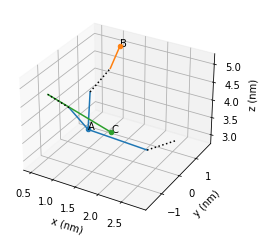

In [54]:

import matplotlib.pyplot as plt

def real_PDB_3D(Result:bool):
    reaction_chain, int_site, int_site_distance, unique_chain, COM = Result
    coord_list = []
    for i in range(len(unique_chain)):
        coord_list_temp = []
        coord_list_temp.append(COM[i])
        for j in range(len(reaction_chain)):
            if unique_chain[i] in reaction_chain[j]:
                if unique_chain[i] == reaction_chain[j][0]:
                    coord_list_temp.append(int_site[j][0])
                else:
                    coord_list_temp.append(int_site[j][1])
        coord_list.append(coord_list_temp)
    fig = plt.figure(1)
    color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    ax = fig.gca(projection='3d')
    for i in range(len(coord_list)):
        ax.scatter(coord_list[i][0][0], coord_list[i][0][1], coord_list[i][0][2], color=color_list[i%9])
        ax.text(coord_list[i][0][0], coord_list[i][0][1], coord_list[i][0][2], unique_chain[i], color='k')
        for j in range(1, len(coord_list[i])):
            figure = ax.plot([coord_list[i][0][0], coord_list[i][j][0]], \
                [coord_list[i][0][1], coord_list[i][j][1]], \
                    [coord_list[i][0][2], coord_list[i][j][2]], color=color_list[i%9])
    for i in range(len(int_site)):
        figure = ax.plot([int_site[i][0][0], int_site[i][1][0]], \
            [int_site[i][0][1], int_site[i][1][1]], \
                [int_site[i][0][2], int_site[i][1][2]], linestyle=':', color='k')
    ax.set_xlabel('x (nm)')
    ax.set_ylabel('y (nm)')
    ax.set_zlabel('z (nm)')
    plt.show()

real_PDB_3D(Result=result1)